In [1]:
import numpy as np
import pandas as pd
from pytmle import PyTMLE

In [2]:
target_times = [1.0, 2.0, 3.0, 4.0, 5.0]
np.random.seed(42)

Load a mock dataset with n_samples and two events 1 and 2, in which both group partly depends on x1, x2 and x3, and event_indicator partly depends on group, x1 and x3.

In [3]:
df = pd.read_csv("data.csv", index_col=0)

Define a custom model (exemplified by a model based on DeepSurv) to be cross-fitted in the .fit method.

In [4]:
# imports needed for pycox
import torchtuples as tt
from pycox.models import CoxPH

in_features = 4 # x1, x2, x3, group
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)


model = CoxPH(net, tt.optim.Adam)

Instantiate the PyTMLE class and fit it with both the DeepSurv model, a RandomSurvivalForest and a Cox PH model in the library of the state learner, and a support vector machine classifier + random forest in the library of the stacking classifier for propensity scores.

In [5]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

tmle = PyTMLE(df, 
              col_event_times="event_time", 
              col_event_indicator="event_indicator", 
              col_group="group", 
              target_times=target_times, 
              g_comp=True,
              verbose=3,)

tmle.fit(cv_folds=5, 
         max_updates=100, 
         save_models=True,
         models=[model, RandomSurvivalForest(), CoxPHSurvivalAnalysis()],
         propensity_score_models=[SVC(), RandomForestClassifier()],
         labtrans=None)

Estimating propensity scores...
Estimating hazards and event-free survival...
Estimating censoring survival...
(CoxPH | CoxPH): 0.33133717498504167
(CoxPH | RandomSurvivalForest): 0.3443584032129509
(CoxPH | CoxPHSurvivalAnalysis): 0.3300989092332824
(RandomSurvivalForest | CoxPH): 0.34078314015602335
(RandomSurvivalForest | RandomSurvivalForest): 0.35033435850885214
(RandomSurvivalForest | CoxPHSurvivalAnalysis): 0.33852552776456957
(CoxPHSurvivalAnalysis | CoxPH): 0.32720752041942064
(CoxPHSurvivalAnalysis | RandomSurvivalForest): 0.33778223189242984
(CoxPHSurvivalAnalysis | CoxPHSurvivalAnalysis): 0.3259917615495764
Starting TMLE update loop...
Step 1: Norm PnEIC improved to 0.03738610963954044.
Step 2: Norm PnEIC improved to 0.032172702252415655.
Step 3: Norm PnEIC improved to 0.028141515502480428.
Step 4: Norm PnEIC improved to 0.02603711029965184.
Step 5: Norm PnEIC improved to 0.02430660224593608.
Step 6: Norm PnEIC improved to 0.022755651245339487.
Step 7: Norm PnEIC improved t

(<Figure size 1400x700 with 2 Axes>,
 array([<Axes: title={'center': 'Event 1'}, xlabel='Time', ylabel='Predicted Risk'>,
        <Axes: title={'center': 'Event 2'}, xlabel='Time', ylabel='Predicted Risk'>],
       dtype=object))

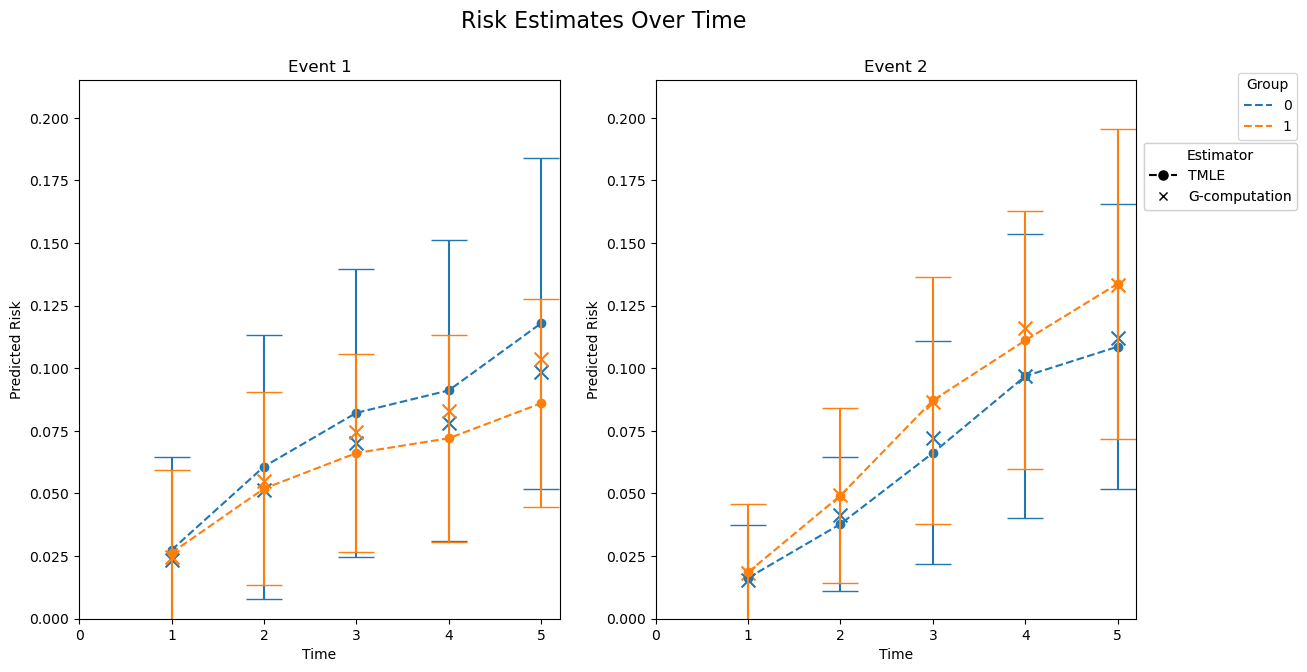

In [6]:
tmle.plot(g_comp=True, use_bootstrap=False)

Since `save_models` was set to `True` in the `fit()` call, you can extract the models used for initial estimates and analyze them further. Note that all cross-fitted models are of type `PycoxWrapper` and only return the name of the wrapped class.

In [7]:
print(tmle.models)
print(tmle.state_learner_cv_fit)

{'propensity_model': StackingClassifier(cv=5,
                   estimators=[('0', SVC()), ('1', RandomForestClassifier())],
                   final_estimator=LogisticRegression(max_iter=1000)), 'risks_model_fold_0': CauseSpecificCoxPHSurvivalAnalysis, 'censoring_model_fold_0': CoxPHSurvivalAnalysis, 'risks_model_fold_1': CauseSpecificCoxPHSurvivalAnalysis, 'censoring_model_fold_1': CoxPHSurvivalAnalysis, 'risks_model_fold_2': CauseSpecificCoxPHSurvivalAnalysis, 'censoring_model_fold_2': CoxPHSurvivalAnalysis, 'risks_model_fold_3': CauseSpecificCoxPHSurvivalAnalysis, 'censoring_model_fold_3': CoxPHSurvivalAnalysis, 'risks_model_fold_4': CauseSpecificCoxPHSurvivalAnalysis, 'censoring_model_fold_4': CoxPHSurvivalAnalysis}
             risks_model        censoring_model      loss
8  CoxPHSurvivalAnalysis  CoxPHSurvivalAnalysis  0.325992
6  CoxPHSurvivalAnalysis                  CoxPH  0.327208
2                  CoxPH  CoxPHSurvivalAnalysis  0.330099
0                  CoxPH             